> FIAP - Faculdade de Informática e Administração Paulista

# Global Solutions 2024.1 - Frontend Development

Vamos desenvolver um modelo de classificação de imagens utilizando uma rede neural convolucional (CNN) para classificar imagens de corais entre branqueados e saudáveis.

## Integrantes

- Cauã Simões Pinheiro - 98319
- Emilly Batista de Oliveira - 97915

## Código

Vamos começar importando as bibliotecas necessárias para o desenvolvimento do projeto. Vamos usar o Tensorflow para nossa rede neural convolucional (CNN)


In [4]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import os
import tensorflow as tf
import tensorflow.keras as keras

tf.get_logger().setLevel("ERROR")

2024-06-04 12:53:32.680549: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-04 12:53:33.404936: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


Agora vamos fazer a leitura dos dados


In [5]:
FOLDER_PATH = "corals/"
HEALTHY_PATH = FOLDER_PATH + "healthy_corals/"
BLEACHED_PATH = FOLDER_PATH + "bleached_corals/"

HEALTHY_COUNT = len(os.listdir(HEALTHY_PATH))
BLEACHED_COUNT = len(os.listdir(BLEACHED_PATH))

print("Healthy corals: ", HEALTHY_COUNT)
print("Bleached corals: ", BLEACHED_COUNT)

Healthy corals:  438
Bleached corals:  485


In [6]:
IMG_WIDTH = 300
IMG_HEIGHT = 225


def load_images(path):
    images = []

    listdir = os.listdir(path)

    for image in listdir:
        img = cv2.imread(path + image)
        img = cv2.resize(img, (IMG_WIDTH, IMG_HEIGHT))
        img = cv2.cvtColor(
            img, cv2.COLOR_BGR2RGB
        )  # Remova essa linha caso aconteça problemas com as cores
        img = np.array(img)

        images.append(img)

    return np.array(images)


healthy_images = load_images(HEALTHY_PATH)
bleached_images = load_images(BLEACHED_PATH)

print("Healthy images shape: ", healthy_images.shape)
print("Bleached images shape: ", bleached_images.shape)

Healthy images shape:  (438, 225, 300, 3)
Bleached images shape:  (485, 225, 300, 3)


Dividir os dados em treino e teste


In [7]:
X = np.concatenate((healthy_images, bleached_images), axis=0)
y = np.concatenate((np.zeros(HEALTHY_COUNT), np.ones(BLEACHED_COUNT)), axis=0)
y = np.array(y, dtype=np.uint8)

print("X shape: ", X.shape)
print("y shape: ", y.shape)

X shape:  (923, 225, 300, 3)
y shape:  (923,)


In [8]:
ds = tf.data.Dataset.from_tensor_slices((X, y))

ds = ds.shuffle(buffer_size=1000)

train_size = int(0.75 * len(ds))
train_ds = ds.take(train_size)

test_ds = ds.skip(train_size)

len(train_ds), len(test_ds)

2024-06-04 12:54:34.463119: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-06-04 12:54:34.566104: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-06-04 12:54:34.570193: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

(692, 231)

In [14]:
batch_size = 24
train_ds = train_ds.batch(batch_size)
test_ds = test_ds.batch(batch_size)

image_batch, label_batch = next(iter(train_ds))

image_batch.shape, label_batch.shape

(TensorShape([24, 225, 300, 3]), TensorShape([24]))

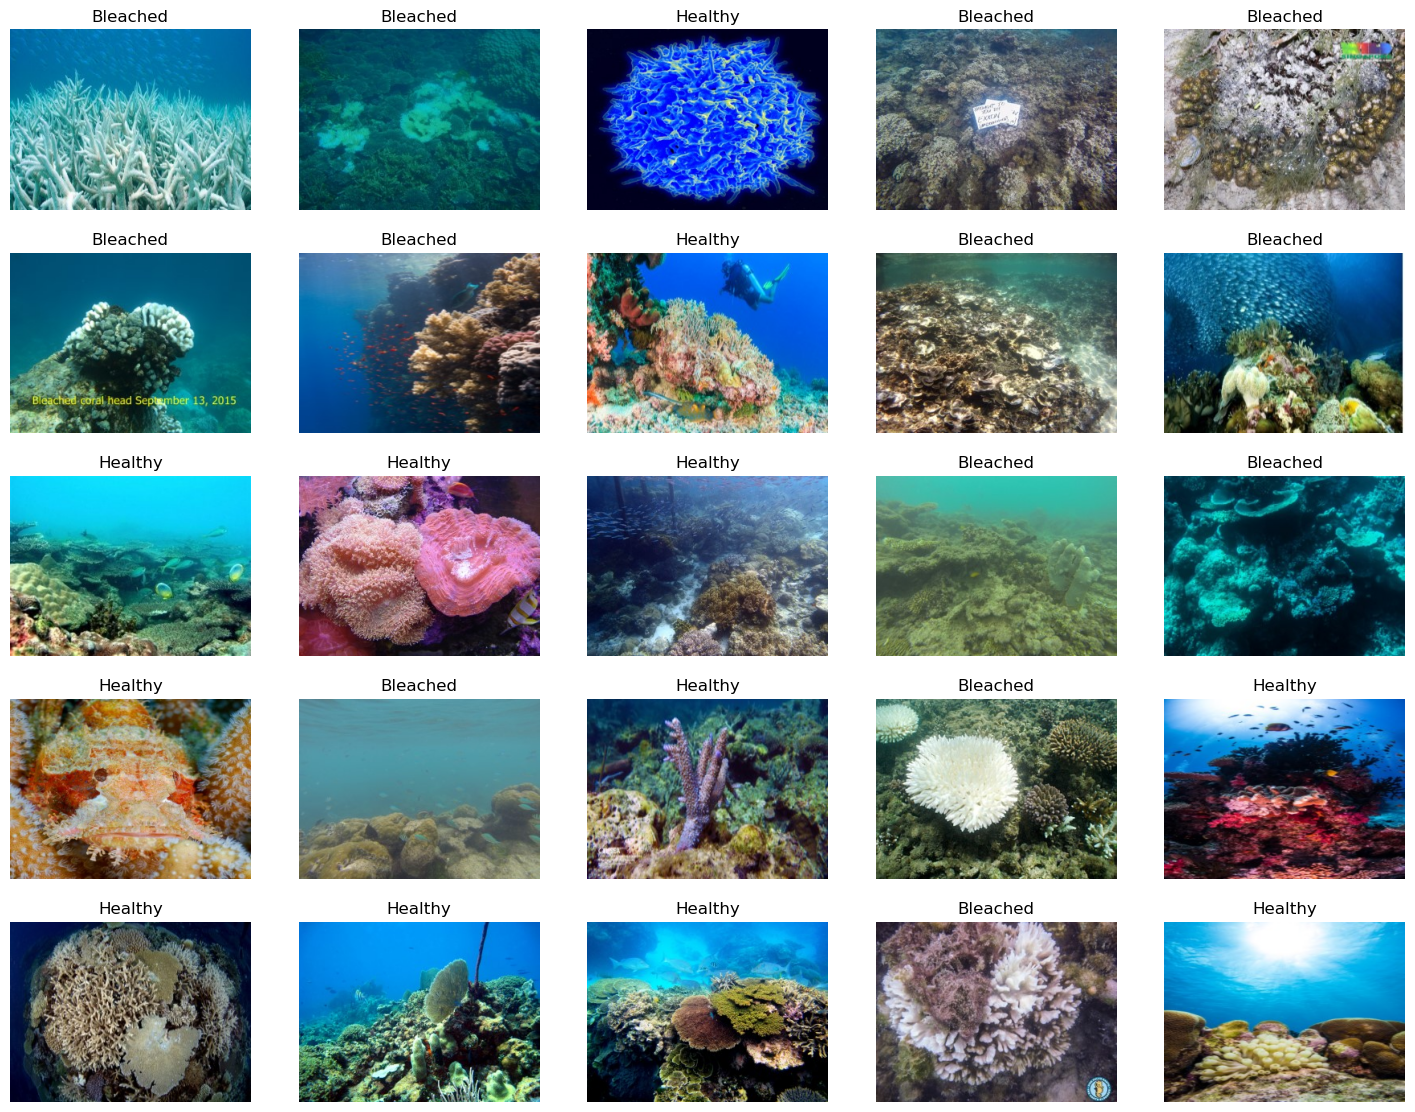

In [15]:
plt.figure(figsize=(18, 14))

for i, (img, label) in enumerate(ds.take(25)):
    plt.subplot(5, 5, i + 1)
    plt.imshow(img.numpy().astype("uint8"))
    plt.title("Healthy" if label.numpy() == 0 else "Bleached")
    plt.axis("off")

plt.show()

### Criação do modelo

Agora que temos nossos dados de treinamento, vamos criar o modelo de classificação de imagens. Vamos usar uma rede neural convolucional (CNN) para isso.


In [13]:
from tensorflow.keras import layers, losses, optimizers, callbacks

model = keras.Sequential()

model.add(layers.Input(shape=(IMG_HEIGHT, IMG_WIDTH, 3)))

model.add(layers.Conv2D(25, 5, padding="same", activation="relu"))
model.add(layers.Conv2D(16, 3, padding="same", activation="relu"))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))
model.add(layers.Conv2D(64, 3, activation="relu"))
model.add(layers.Conv2D(32, 4, activation="relu"))

model.add(layers.Flatten())

model.add(layers.Dense(128, activation="relu", use_bias=True))
model.add(layers.Dense(64, activation="relu", use_bias=True))
model.add(layers.Dropout(0.2))
model.add(layers.Dense(28, activation="relu", use_bias=True))

model.add(layers.Dense(1, activation="sigmoid"))

optimizer = optimizers.Adam(learning_rate=0.001)

METRICS = [
    keras.metrics.BinaryAccuracy(name="accuracy"),
    keras.metrics.Precision(name="precision"),
]

model.compile(optimizer=optimizer, loss=losses.BinaryCrossentropy(), metrics=METRICS)

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 225, 300, 25)      1900      
                                                                 
 conv2d_5 (Conv2D)           (None, 225, 300, 16)      3616      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 112, 150, 16)      0         
 g2D)                                                            
                                                                 
 conv2d_6 (Conv2D)           (None, 110, 148, 64)      9280      
                                                                 
 conv2d_7 (Conv2D)           (None, 107, 145, 32)      32800     
                                                                 
 flatten_1 (Flatten)         (None, 496480)            0         
                                                      

In [20]:
history = model.fit(train_ds, validation_data=test_ds, epochs=10)

history = history.history

Epoch 1/20
29/29 [==============================] - 3s 107ms/step - loss: 0.3415 - accuracy: 0.8194 - precision: 0.7668 - val_loss: 0.2911 - val_accuracy: 0.8528 - val_precision: 0.7925
Epoch 2/20
29/29 [==============================] - 3s 107ms/step - loss: 0.2731 - accuracy: 0.8540 - precision: 0.8004 - val_loss: 0.2346 - val_accuracy: 0.8874 - val_precision: 0.8356
Epoch 3/20
29/29 [==============================] - 3s 105ms/step - loss: 0.2499 - accuracy: 0.8613 - precision: 0.8105 - val_loss: 0.2345 - val_accuracy: 0.8831 - val_precision: 0.8299
Epoch 4/20
29/29 [==============================] - 3s 107ms/step - loss: 0.2024 - accuracy: 0.9017 - precision: 0.8595 - val_loss: 0.1475 - val_accuracy: 0.9177 - val_precision: 0.8921
Epoch 5/20
29/29 [==============================] - 3s 108ms/step - loss: 0.3126 - accuracy: 0.8728 - precision: 0.8255 - val_loss: 0.4772 - val_accuracy: 0.7273 - val_precision: 0.6629
Epoch 6/20
29/29 [==============================] - 3s 110ms/step - lo

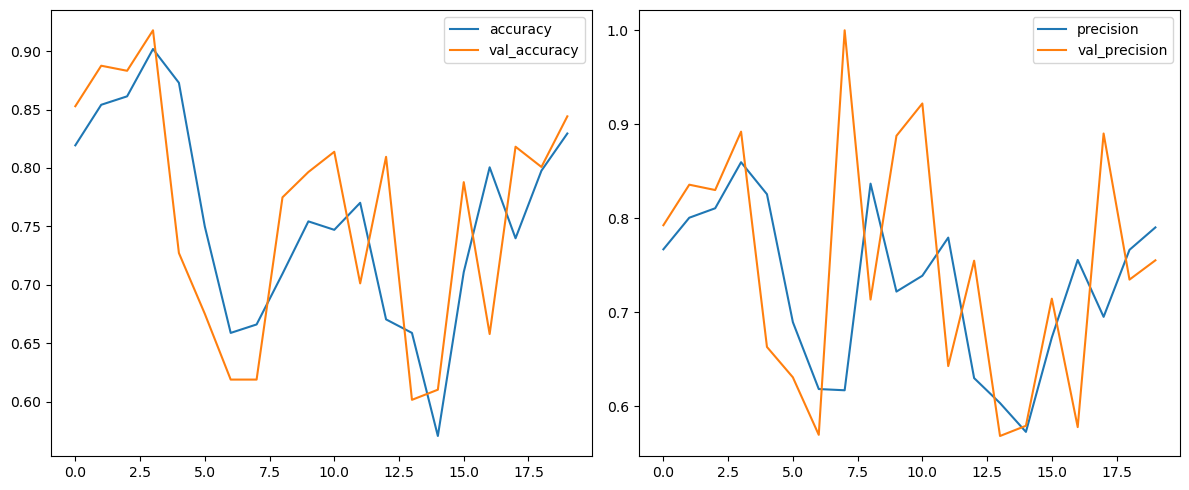

In [21]:
plt.figure(figsize=(12, 5))


ax = plt.subplot(1, 2, 1)
ax.plot(history["accuracy"], label="accuracy")
ax.plot(history["val_accuracy"], label="val_accuracy")
plt.legend()

ax = plt.subplot(1, 2, 2)
ax.plot(history["precision"], label="precision")
ax.plot(history["val_precision"], label="val_precision")
plt.legend()

plt.tight_layout()
plt.show()

### Salvando o modelo

Vamos salvar o modelo para uso futuro


In [22]:
model.save("coral_model.keras")

## Conclusão

Temos nosso modelo treinado e salvo. Agora podemos usá-lo para classificar imagens de corais entre branqueados e saudáveis. Rode o arquivo `app.py` para rodar o backend que irá servir o modelo treinado.
